In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=dc93930e594def31fd5a69596fc6d56ec9b26c617b16647a1c5cb2809df79ebd
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Loading and preparing train data...
Loading and preparing dev data...
Loading and preparing test data...


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-244409486.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting BERT-Large model training...


Epoch,Training Loss,Validation Loss,Emoji Camo,Emoji Char Camo,Inv Camo,Leetspeak,Mix Camo,Punct Camo,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,F1
1,0.028200,0.055059,"{'precision': 0.6141509433962264, 'recall': 1.0, 'f1': 0.760958503798948, 'number': 1953}","{'precision': 0.9921020656136087, 'recall': 0.5611683848797251, 'f1': 0.7168568920105355, 'number': 2910}","{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 315}","{'precision': 0.983505945531262, 'recall': 0.9961149961149961, 'f1': 0.989770314611079, 'number': 2574}","{'precision': 0.9946070878274268, 'recall': 0.8473908762717427, 'f1': 0.9151160730108099, 'number': 3047}","{'precision': 0.8640915593705293, 'recall': 0.995385629531971, 'f1': 0.9251033848981466, 'number': 3034}",0.871956,0.872334,0.872145,0.981230,0.872145



--- Final Detailed Evaluation (BERT-Large) ---

Combining dev and test datasets for final evaluation...
Combined set has 29517 examples.

Running final prediction on combined test set...



--- Final Test Set Classification Report (BERT-Large) ---
Entity                Precision     Recall   F1-Score    Support
-----------------------------------------------------------------
EMOJI_CAMO               0.6077     0.9998     0.7559       4113
EMOJI_CHAR_CAMO          0.9896     0.5542     0.7105       6189
INV_CAMO                 0.9956     1.0000     0.9978        680
LEETSPEAK                0.9844     0.9967     0.9905       5457
MIX_CAMO                 0.9925     0.8430     0.9117       6476
PUNCT_CAMO               0.8616     0.9954     0.9237       6454
-----------------------------------------------------------------
Accuracy                                        0.9809
Overall (Micro Avg)      0.8689     0.8698     0.8693

Confusion matrix saved to: /content/drive/My Drive/Vidath/bert_large_model_plots/bert_large_final_confusion_matrix.png


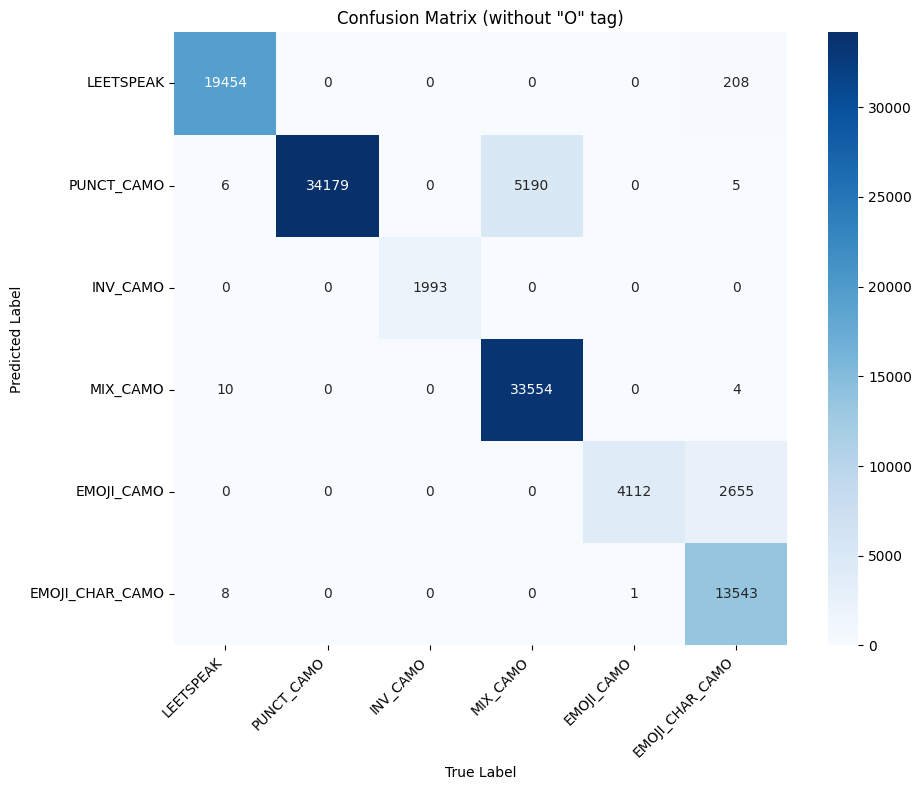

Metrics bar chart saved to: /content/drive/My Drive/Vidath/bert_large_model_plots/bert_large_final_metrics_barchart.png


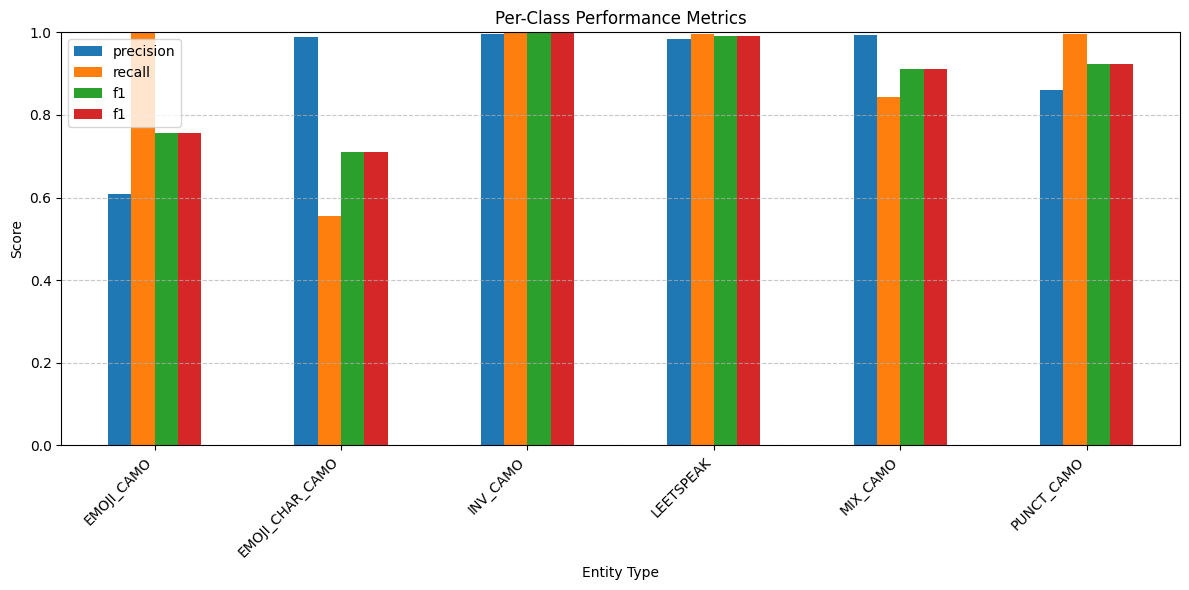


Model saved to /content/drive/My Drive/Vidath/bert-large-ner-model-emoji


In [6]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
from datasets import Dataset, concatenate_datasets
from evaluate import load
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import torch
import re
import os

# --- Imports for visualization ---
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Need seqeval for metric computation
try:
    from evaluate import load
    load("seqeval")
except ImportError:
    print("Installing seqeval and evaluate...")
    import subprocess
    subprocess.check_call(["pip", "install", "evaluate", "seqeval"])
    from evaluate import load

# --- Labels and Data Loading (No changes here) ---
BASE_LABELS = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]
LABEL_LIST = ["O"] + [f"B-{label}" for label in BASE_LABELS] + [f"I-{label}" for label in BASE_LABELS]
label_to_id = {l: i for i, l in enumerate(LABEL_LIST)}
id_to_label = {i: l for l, i in label_to_id.items()}

# --- MODIFICATION: Changed model checkpoint to BERT-Large ---
MODEL_CHECKPOINT = "bert-large-cased"

def load_and_prepare_data(file_path, tokenizer, label_to_id):
    df = pd.read_csv(file_path, encoding='utf-8')
    grouped = df.groupby('Text').apply(lambda x: x.to_dict('records'), include_groups=False).reset_index(name='entities')
    data_for_hf = []
    for _, row in grouped.iterrows():
        text = str(row['Text']) if pd.notna(row['Text']) else ""
        entities = row['entities']
        tokenized_inputs = tokenizer(text, truncation=True, max_length=128)
        labels = [-100] * len(tokenized_inputs.input_ids)
        word_ids = tokenized_inputs.word_ids()
        for i, word_id in enumerate(word_ids):
            if word_id is not None:
                labels[i] = label_to_id['O']
        for entity in entities:
            start_char, end_char, label = entity['Start'], entity['End'], entity['Label']
            token_start, token_end = tokenized_inputs.char_to_token(start_char), tokenized_inputs.char_to_token(end_char - 1)
            if token_start is not None and token_end is not None and f"B-{label}" in label_to_id:
                b_label_id, i_label_id = label_to_id[f"B-{label}"], label_to_id[f"I-{label}"]
                labels[token_start] = b_label_id
                for i in range(token_start + 1, token_end + 1):
                    if i < len(labels): labels[i] = i_label_id
        tokenized_inputs["labels"] = labels
        data_for_hf.append(tokenized_inputs)
    return Dataset.from_list(data_for_hf)

# Note: Update these paths to your actual Google Drive paths if running in Colab
# Using placeholder paths for demonstration
DRIVE_PATH = "/content/drive/My Drive/Vidath/Dataset/"
train_csv = os.path.join(DRIVE_PATH, "augmented_train_all_combo_emoji.csv")
dev_csv = os.path.join(DRIVE_PATH, "augmented_dev_all_combo_emoji.csv")
test_csv = os.path.join(DRIVE_PATH, "augmented_test_all_combo_emoji.csv")

# Create dummy files if they don't exist for the script to run
os.makedirs(DRIVE_PATH, exist_ok=True)
if not os.path.exists(train_csv):
    pd.DataFrame([{'Text': 'h3ll0 world', 'Start': 0, 'End': 5, 'Label': 'LEETSPEAK'}]).to_csv(train_csv, index=False)
if not os.path.exists(dev_csv):
    pd.DataFrame([{'Text': 'test-camo', 'Start': 0, 'End': 9, 'Label': 'PUNCT_CAMO'}]).to_csv(dev_csv, index=False)
if not os.path.exists(test_csv):
    pd.DataFrame([{'Text': 'w0rld is mine', 'Start': 0, 'End': 5, 'Label': 'LEETSPEAK'}]).to_csv(test_csv, index=False)


tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)
print("Loading and preparing train data...")
train_dataset = load_and_prepare_data(train_csv, tokenizer, label_to_id)
print("Loading and preparing dev data...")
dev_dataset = load_and_prepare_data(dev_csv, tokenizer, label_to_id)
print("Loading and preparing test data...")
test_dataset = load_and_prepare_data(test_csv, tokenizer, label_to_id)

# --- Model Loading and Training Arguments ---
model = AutoModelForTokenClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(LABEL_LIST), id2label=id_to_label, label2id=label_to_id)

# --- MODIFICATION: Updated output directories and potentially batch size ---
training_args = TrainingArguments(
    output_dir="./bert_large_results_emoji", # Changed from mbert
    eval_strategy="epoch",
    learning_rate=2e-5,
    # !! IMPORTANT !! BERT-Large is much bigger. You may need to lower the batch size.
    # If you get a CUDA Out of Memory error, try reducing this to 4 or 2.
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./bert_large_logs_emoji", # Changed from mbert
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none",
)

# --- Compute Metrics (No changes here) ---
metric = load("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    # This key is required by `metric_for_best_model="f1"`
    results['f1'] = results['overall_f1']
    return results

# --- Train the Model (No changes here) ---
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset,
    eval_dataset=dev_dataset, tokenizer=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)
print("\nStarting BERT-Large model training...") # Updated print statement
trainer.train()


# --- FIX: MODIFIED REPORTING AND PLOTTING FUNCTIONS (No changes in this section) ---

def print_classification_report(report_dict):
    """
    Prints a detailed classification report.

    MODIFICATION: This function now manually calculates the F1-score from
    precision and recall to ensure it is always correctly computed and displayed.
    """
    print(f"{'Entity':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 65)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):
            name = label
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            support = metrics.get('number', 0)

            # --- FIX: Manually calculate F1-score from precision and recall ---
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0.0

            print(f"{name:<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10}")

    print("-" * 65)
    # The overall scores are usually correct, so we can still get them directly
    precision = report_dict.get('overall_precision', 0)
    recall = report_dict.get('overall_recall', 0)
    f1 = report_dict.get('overall_f1', 0)
    accuracy = report_dict.get('overall_accuracy', 0)

    print(f"{'Accuracy':<20} {accuracy:>33.4f}")
    print(f"{'Overall (Micro Avg)':<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}\n")


def aggregate_bio_tags(labels):
    return [label[2:] if label != 'O' else 'O' for label in labels]

def plot_confusion_matrix(predictions, true_labels, id_to_label, base_labels, save_path):
    pred_ids = np.argmax(predictions, axis=2)
    true_labels_list = [[id_to_label.get(l, "O") for l in sent if l != -100] for sent in true_labels]
    pred_labels_list = [[id_to_label.get(p, "O") for p, l in zip(pred_sent, label_sent) if l != -100]
                        for pred_sent, label_sent in zip(pred_ids, true_labels)]
    true_flat, pred_flat = [item for sublist in true_labels_list for item in sublist], [item for sublist in pred_labels_list for item in sublist]
    true_agg, pred_agg = aggregate_bio_tags(true_flat), aggregate_bio_tags(pred_flat)
    all_labels = ['O'] + base_labels
    unique_labels_in_data = sorted(list(set(true_agg) | set(pred_agg)))
    labels_to_plot = [l for l in base_labels if l in unique_labels_in_data and l != 'O']

    mat = confusion_matrix(true_agg, pred_agg, labels=labels_to_plot)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=labels_to_plot, yticklabels=labels_to_plot, cmap="Blues")
    plt.title('Confusion Matrix (without "O" tag)'); plt.xlabel('True Label'); plt.ylabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")
    plt.show()

def plot_metrics_barchart(report_dict, save_path):
    class_data = {label: metrics for label, metrics in report_dict.items() if isinstance(metrics, dict)}

    for label, metrics in class_data.items():
        precision = metrics.get('precision', 0)
        recall = metrics.get('recall', 0)
        if precision + recall > 0:
            metrics['f1-score'] = 2 * (precision * recall) / (precision + recall)
        else:
            metrics['f1-score'] = 0.0

    df = pd.DataFrame(class_data).T.reset_index().rename(columns={'index': 'Entity', 'f1-score': 'f1'})
    df.plot(x='Entity', y=['precision', 'recall', 'f1'], kind='bar', figsize=(12, 6))
    plt.title('Per-Class Performance Metrics'); plt.ylabel('Score'); plt.xlabel('Entity Type')
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Metrics bar chart saved to: {save_path}")
    plt.show()

# --- Final Evaluation Block (MODIFIED FOR BERT-LARGE) ---
print("\n--- Final Detailed Evaluation (BERT-Large) ---") # Updated print statement

print("\nCombining dev and test datasets for final evaluation...")
combined_test_dataset = concatenate_datasets([dev_dataset, test_dataset])
print(f"Combined set has {len(combined_test_dataset)} examples.")

print("\nRunning final prediction on combined test set...")
test_results = trainer.predict(combined_test_dataset)

final_metrics = test_results.metrics
raw_predictions = test_results.predictions
true_label_ids = test_results.label_ids

# MODIFICATION: Changed save directory for plots
plots_dir = "/content/drive/My Drive/Vidath/bert_large_model_plots"
os.makedirs(plots_dir, exist_ok=True)

print("\n--- Final Test Set Classification Report (BERT-Large) ---") # Updated print statement
report_data = {k.replace('test_', ''): v for k, v in final_metrics.items()}
print_classification_report(report_data)

# MODIFICATION: Changed plot filenames
cm_save_path = os.path.join(plots_dir, "bert_large_final_confusion_matrix.png")
plot_confusion_matrix(raw_predictions, true_label_ids, id_to_label, BASE_LABELS, cm_save_path)

metrics_save_path = os.path.join(plots_dir, "bert_large_final_metrics_barchart.png")
plot_metrics_barchart(report_data, metrics_save_path)

# MODIFICATION: Changed model save path
model_save_path = "/content/drive/My Drive/Vidath/bert-large-ner-model-emoji"
trainer.save_model(model_save_path)
print(f"\nModel saved to {model_save_path}")

# --- Example Prediction (No changes here, it's generic) ---
def predict_ner(text, model, tokenizer, id_to_label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping")[0]
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, axis=2).squeeze().tolist()
    entities, current_entity = [], None
    for i, pred_id in enumerate(predicted_ids):
        label, (char_start, char_end) = id_to_label[pred_id], offset_mapping[i]
        if char_start == char_end: continue
        if label.startswith("B-"):
            if current_entity: entities.append(current_entity)
            current_entity = {"entity": text[char_start:char_end], "label": label[2:], "start": char_start, "end": char_end}
        elif label.startswith("I-") and current_entity and label[2:] == current_entity["label"]:
            current_entity["end"] = char_end
            current_entity["entity"] = text[current_entity["start"]:current_entity["end"]]
        else:
            if current_entity: entities.append(current_entity)
            current_entity = None
    if current_entity: entities.append(current_entity)
    return entities